In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import scipy

import matplotlib.pyplot as plt
from pathlib import Path
from read_data import get_network_df, get_corrs, get_full_df
from numba.core import types
import graph_tool
import numba
import time 

from numba import njit
from graph_tool.topology import shortest_distance
import pandas as pd
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types

from transport_problem import OptimParams, DualOracle, HyperParams
from subgd import OracleStacker, ustm_mincost_mcf
from get_graph import get_graph_by_name
from oracle_utils import AlgoResults
from sinkhorn import Sinkhorn
from transport_problem import OptimParams, DualOracle, HyperParams
from sinkhorn_appendix import ustm_sinkhorn_mincost_mcf, OracleSinkhornStacker
from get_graph import get_graph_by_name
from transport_problem import DualOracle, OptimParams
from acrcd_no_adaptive import ACRCDOracleStacker, ACRCD_star

In [70]:
net_df, corrs = get_graph_by_name("SiouxFalls")
graph = gt.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

l = np.maximum(np.sum(corrs, axis=1), 1e-6)
w = np.maximum(np.sum(corrs, axis=0), 1e-6)

zones_num = len(l)
sources = np.arange(zones_num)
targets = np.arange(zones_num)

params = HyperParams(gamma=10, mu_pow=0.25, rho=0.15)

graph type:  SiouxFalls


In [71]:
oracle = DualOracle(graph, l, w, params, net_df=net_df)

ustm_stacker = OracleStacker(oracle, graph, sources, targets)
sinkhorn_stacker = OracleSinkhornStacker(oracle, graph, sources, targets, l, w, params)
acrcd_stacker = ACRCDOracleStacker(oracle, graph, sources, targets)

In [72]:
def calc_custom_metric(results, oracle_stacker):
    x = results.history_count_calls
    dual_gap = results.history_dual_gap
    dual_gap_clipped = np.maximum(0, dual_gap)
    la_mu_end_norm = np.linalg.norm(np.hstack([oracle_stacker.optim_params.la, oracle_stacker.optim_params.mu]))               
    metric = 2 * np.array(results.history_la_mu_grad_norm) * la_mu_end_norm + dual_gap_clipped
    return metric

In [73]:
def custom_plot(x, y, label=None):
    plt.plot(x, y, label=label)
    plt.legend()
    plt.yscale("log")
    plt.show()

In [108]:
def plot_to_csv(x, y, csv_name):
    data = list(zip(x, y))
    if len(data) > 1000:
        step = len(data) // 200
        data = [data[i] for i in range(0, len(data), step)]
    df = pd.DataFrame(data)
    df.to_csv(csv_name, index=False)

## Testing USTM

In [74]:
t_start = time.time()
results_ustm = ustm_mincost_mcf(ustm_stacker,  eps_abs=1e-4, eps_cons_abs=1e-4, max_iter=5000, stop_by_crit=True)
print(f"total time taken: {time.time() - t_start}")

first exceeding the limits:  0.16041110063971112
start optimizing
first dual_func:  11.621762504548435


100%|██████████| 5000/5000 [00:31<00:00, 156.41it/s]

total time taken: 31.971612453460693


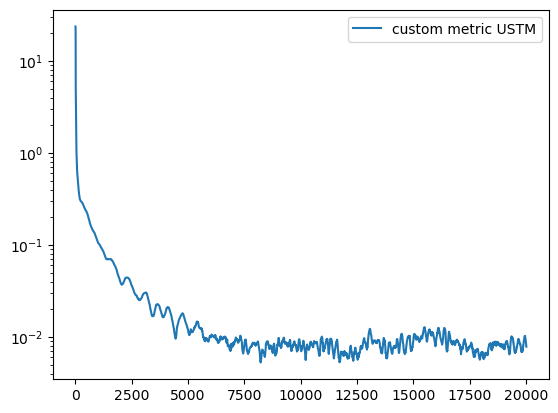

In [99]:
custom_metric_ustm = calc_custom_metric(results_ustm, ustm_stacker)
custom_plot(results_ustm.history_count_calls, custom_metric_ustm, label="custom metric USTM")
# custom_plot(custom_metric_ustm, results_ustm.history_count_calls, label="custom metric USTM")

In [100]:
plot_to_csv(results_ustm.history_count_calls, custom_metric_ustm, "paper_ustm.csv")

## Testing USTM + Sinkhorn

In [77]:
t, results_t, results_sinkhorn = ustm_sinkhorn_mincost_mcf(sinkhorn_stacker,  eps_abs=1e-4, eps_cons_abs=1e-4,
                                                max_iter=100, stop_by_crit=True)

51.63220274406228 4.210227987645911e-08
start optimizing


100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


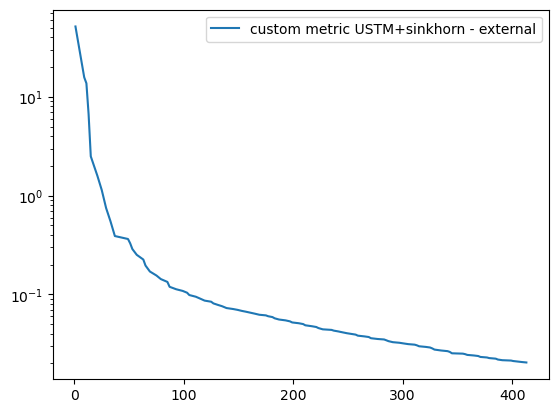

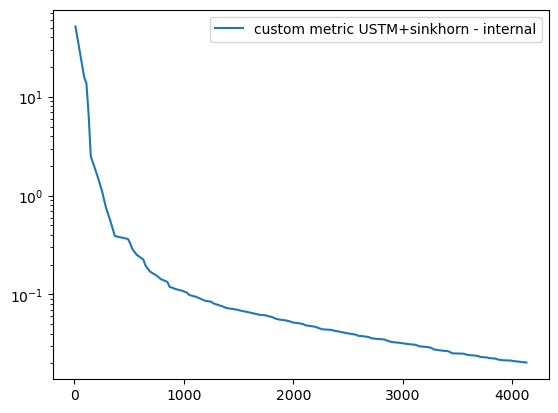

In [101]:
custom_metric_ustm = calc_custom_metric(results_sinkhorn, sinkhorn_stacker)
custom_plot(results_t.history_count_calls, custom_metric_ustm, label="custom metric USTM+sinkhorn - external")
custom_plot(results_sinkhorn.history_count_calls, custom_metric_ustm, label="custom metric USTM+sinkhorn - internal")

In [102]:
plot_to_csv(results_t.history_count_calls, custom_metric_ustm, "paper_ustm_sinkhorn_outer.csv")

In [103]:
plot_to_csv(results_sinkhorn.history_count_calls, custom_metric_ustm, "paper_ustm_sinkhorn_inner.csv")

## ACRCD

In [79]:
acrcd_results_t, acrcd_results_la_mu = ACRCD_star(acrcd_stacker, *acrcd_stacker.get_init_vars_block(), K=10000, L1_init=2, L2_init=5e-2)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/jupyter/transport/transport_network_optimization/transport_problem.py:168: RuntimeWarning: divide by zero encountered in log
  return np.sum(self.sigma(f)) + self.params.gamma * np.sum(d * np.log(d))
/home/jupyter/transport/transport_network_optimization/transport_problem.py:168: RuntimeWarning: invalid value encountered in multiply
  return np.sum(self.sigma(f)) + self.params.gamma * np.sum(d * np.log(d))
100%|██████████| 10000/10000 [00:15<00:00, 625.90it/s]


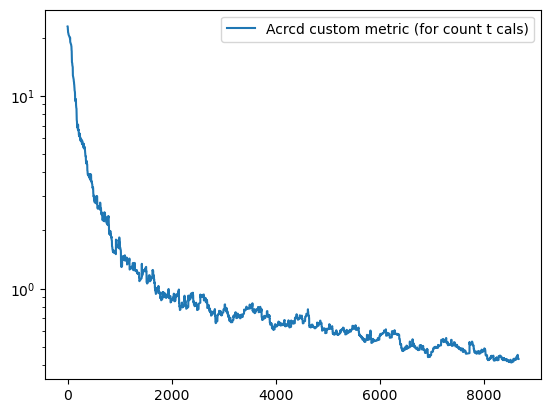

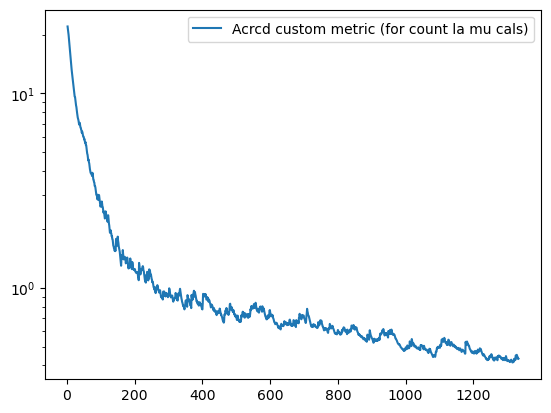

In [104]:
x = acrcd_results_t.history_count_calls
acrcd_custom_metric_t = calc_custom_metric(acrcd_results_t, acrcd_stacker)
custom_plot(x, acrcd_custom_metric_t, label="Acrcd custom metric (for count t cals)")

x = acrcd_results_la_mu.history_count_calls
acrcd_custom_metric_la_mu = calc_custom_metric(acrcd_results_la_mu, acrcd_stacker, )
custom_plot(x, acrcd_custom_metric_la_mu, label="Acrcd custom metric (for count la mu cals)")

In [109]:
plot_to_csv(x, acrcd_custom_metric_t, "paper_acrcd_t.csv")
plot_to_csv(x, acrcd_custom_metric_la_mu, "paper_acrcd_mu.csv")